## Collatz beta notebook

In [17]:
"""
This notebook analyses the betas of collatz sequences and their relationship
to other components. The beta  of an odd collatz number is defined by the 
following equation: beta = 1 + 1/k*x where x is the odd number. 
"""

# Fix possible import problems
import sys
sys.path.append("..")

# Imports
from fractions import Fraction
import random as rnd
import matplotlib.pyplot as plt
from math import log2
import pandas as pd
from collatz import commons as com
from collatz import generator as gen


# Configuration
k = 3
max_value = 101
max_iterations = 30
start_value = rnd.randint(1, max_value)

if start_value % 2 == 0:
    start_value = start_value + 1

# start_value = 35

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Create a collatz sequence and analyse it
analysis_frame = gen.generate_odd_collatz_sequence(
    start_value=start_value, k=k, max_iterations=max_iterations)

# Drop last row if sequences has ended with 1
if len(analysis_frame) > 1:
    analysis_frame = analysis_frame[:-1]

# Derive additional fields
analysis_frame["n"] = analysis_frame.index + 1
analysis_frame.insert(1, "v1", [start_value] * len(analysis_frame))

# Calculate alpha
analysis_frame["alpha"] = analysis_frame["next_collatz"].apply(com.trailing_zeros)
analysis_frame["alpha"] = analysis_frame["alpha"].astype("int64")
analysis_frame["alpha_sum"] = analysis_frame["alpha"].cumsum()
analysis_frame["alpha_max"] = analysis_frame["n"] * log2(k) + log2(start_value)
analysis_frame["alpha_max"] = analysis_frame["alpha_max"].astype('int64') + 1

# Calculate beta
analysis_frame["beta_i"] = 1 + 1/(k*analysis_frame["collatz"])
analysis_frame["beta"] = analysis_frame["beta_i"].cumprod()
analysis_frame["beta_log"] = analysis_frame["beta"].apply(log2)
analysis_frame["beta_log_max"] = analysis_frame["alpha_max"] - \
                             analysis_frame["n"] * log2(k) - log2(start_value)

analysis_frame["beta_log_pred"] = (analysis_frame["n"] * log2(k)).astype('int64') + 1 - \
                                   analysis_frame["n"] * log2(k)

analysis_frame["beta_max"] = 2**analysis_frame["beta_log_max"]
analysis_frame["beta_pred"] = 2**analysis_frame["beta_log_pred"]

analysis_frame["beta_frac"] = analysis_frame["beta"].apply(
    Fraction.from_float).apply(Fraction.limit_denominator)

analysis_frame["beta_max_frac"] = analysis_frame["beta_max"].apply(
    Fraction.from_float).apply(Fraction.limit_denominator)

analysis_frame["beta_pred_frac"] = analysis_frame["beta_pred"].apply(
    Fraction.from_float).apply(Fraction.limit_denominator)

# Print results
print_frame = analysis_frame[[
    "n", "collatz","next_odd",
    "beta", "beta_max", "beta_pred", 
    "beta_frac", "beta_max_frac", "beta_pred_frac"
]]

print_frame.columns = ["n","vi", "vi_1",
                       "b", "b_max", "b_pred", 
                       "b_frac", "b_max_frac", "b_pred_frac"]

final_beta = analysis_frame["beta"][len(analysis_frame)-1]

print("v1:", start_value, " K:", k, 
      " beta:", final_beta, 
      "\n")

print(print_frame.to_string(index=False), "\n")

v1: 67  K: 3  beta: 1.1926831321217417 

 n   vi  vi_1         b     b_max    b_pred         b_frac     b_max_frac b_pred_frac
 1   67   101  1.004975  1.273632  1.333333        202/201        256/201         4/3
 2  101    19  1.008292  1.698176  1.777778        608/603       1024/603        16/9
 3   19    29  1.025981  1.132117  1.185185      1856/1809      2048/1809       32/27
 4   29    11  1.037774  1.509490  1.580247      5632/5427      8192/5427      128/81
 5   11    17  1.069222  1.006326  1.053498    17408/16281    16384/16281     256/243
 6   17    13  1.090187  1.341769  1.404664    53248/48843    65536/48843    1024/729
 7   13     5  1.118140  1.789025  1.872885  163840/146529  262144/146529   4096/2187
 8    5     1  1.192683  1.192683  1.248590  524288/439587  524288/439587   8192/6561 



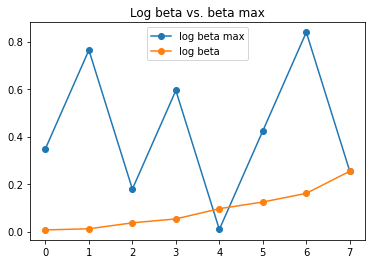

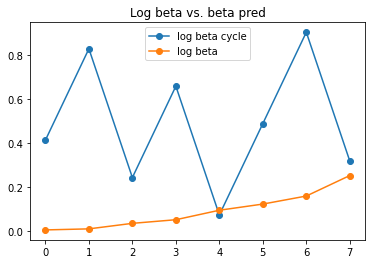

In [18]:
# Plot results
plt.figure()
plt.title("Log beta vs. beta max")
plt.plot(analysis_frame["beta_log_max"], "-o", label="log beta max")
plt.plot(analysis_frame["beta_log"], "-o", label='log beta')
plt.legend()

plt.figure()
plt.title("Log beta vs. beta pred")
plt.plot(analysis_frame["beta_log_pred"], "-o", label="log beta cycle")
plt.plot(analysis_frame["beta_log"], "-o", label='log beta')
plt.legend()
plt.show()
